## Problems/Challenges (w/ possible solns), To-do work
1. **Class Imbalance**

    **Data Level Techniques:**
    
      * Resampling Methods (oversampling minority, undersampling majority, hybrid sampling)
      
      * Data Augmentation (Image and Domain-specific augmentation)
    
   **Algo-level Techniques:**
    
      * Class Weights Adjustments (Weighted Loss fn, **Focal Loss**)
      * Ensemble Models (Balanced ensemble, Bayesian ensemble)
      
   **Uncertainty-specific techniques:**
   
     * Weighted Evidential Learning: 
       
      When dealing with class imbalance, it’s crucial to ensure that uncertainty is also appropriately calibrated. For instance, you can apply class-specific weights in the evidential deep learning loss function to make the model more sensitive to uncertainty in minority classes. This prevents the model from being overconfident in classifying underrepresented examples.

## Questions to be answered

* **Will data augmentation increase aleatoric uncertainty? If yes, then why augment data?**


If augmentations add realistic diversity, aleatoric uncertainty may not increase significantly. If augmentations introduce unrealistic or highly ambiguous data, it could increase aleatoric uncertainty.


## 1.  Import Libraries

In [1]:
import os
import numpy as np 
import pandas as pd 
from glob import glob
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# !pip install autokeras
# import autokeras as ak

In [2]:
import torch
import torch.nn as nn
import torchvision as tv
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
# from torchvision import models
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torchvision.transforms as transforms
from torch.distributions import Dirichlet
from torch.distributions.kl import kl_divergence

import copy
import time
# import keras
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 2. Loading data and merging images

In [4]:
base_dir = os.path.join('..', '/kaggle/input/skin-cancer-mnist-ham10000')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

# more friendly labels
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

### 2.1 Merge images into a single folder

In [4]:
# # Dump all images into a folder and specify the path:
# os.makedirs("/kaggle/working/data/all_images/", exist_ok=True)
# # Path to destination directory where we want subfolders
# # os.makedirs("/kaggle/working/data/reorganized/", exist_ok=True)
# data_dir = "/kaggle/working/data/all_images/"
# # dest_dir = "/kaggle/working/data/reorganized/"

In [5]:
# # Function to copy .jpg files from source folder to destination folder
# def copy_jpg_files(source_folder, destination_folder):
#     for filename in os.listdir(source_folder):
#         if filename.endswith('.jpg'):
#             source_path = os.path.join(source_folder, filename)
#             destination_path = os.path.join(destination_folder, filename)
#             shutil.copy2(source_path, destination_path)

In [6]:
# # Copy files from both HAM folders
# copy_jpg_files("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1",
#                "/kaggle/working/data/all_images")
# copy_jpg_files("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2",
#                "/kaggle/working/data/all_images")

### 2.2 Load and work with csv file

In [5]:
skin_df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))
skin_df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [6]:
skin_df['path'] = skin_df['image_id'].map(image_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [15]:
skin_df.loc[0, 'path']

'/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027419.jpg'

In [14]:
skin_df['cell_type_idx'].unique()

array([2, 4, 3, 5, 6, 1, 0], dtype=int8)

## 3. Orig/RESIZED IMG, label encoding and some Hyperparameters

In [8]:
# SHAPE OF ORIGINAL IMAGES
np.asarray(Image.open(skin_df.loc[0, 'path'])).shape 

(450, 600, 3)

In [7]:
# #RESIZED
# resized = 224
resized = 64
bs = 32 # Batch size

In [7]:
#To show images. Time taking method!
# skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((resized, resized))))

In [8]:
# # Encode skin lesion type 'dx' to categorical (Keras lib use)
# le = LabelEncoder()
# le.fit(skin_df['dx'])
# LabelEncoder()
# print(le.classes_)

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [9]:
# skin_df['label'] = le.transform(skin_df['dx'])

In [10]:
skin_df.tail(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
10005,HAM_0005579,ISIC_0028393,akiec,histo,80.0,male,face,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10006,HAM_0004034,ISIC_0024948,akiec,histo,55.0,female,face,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10007,HAM_0001565,ISIC_0028619,akiec,histo,60.0,female,face,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10008,HAM_0001576,ISIC_0033705,akiec,histo,60.0,male,face,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10009,HAM_0005705,ISIC_0031430,akiec,histo,75.0,female,lower extremity,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Melanoma,5


In [7]:
# labels = skin_df['dx'].unique().tolist()
# label_images = []

# # Copy images to newly created folders
# for label in labels:
#     os.mkdir(dest_dir + label + "/")
#     sample = skin_df[skin_df['dx'] == label]['image_id']
#     label_images.extend(sample)
    
#     for id in label_images:
#         shutil.copyfile((data_dir + id + ".jpg"), (dest_dir + label + "/" + id + ".jpg"))
#     label_images = []

In [12]:
# num_samples = 4
# fig, m_axs = plt.subplots(7, num_samples, figsize=(4*num_samples, 3*7))
# for n_axs, (type_name, type_rows) in zip(m_axs, 
#                                          skin_df.sort_values(['cell_type']).groupby('cell_type')):
#     n_axs[0].set_title(type_name)
#     for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(num_samples, random_state=1234).iterrows()):
#         c_ax.imshow(c_row['image'])
#         c_ax.axis('off')
# fig.savefig('HAM10K_samples.png', dpi=300)

## 4. EDA

In [34]:
skin_df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
image            0
label            0
dtype: int64

In [8]:
skin_df['age'].fillna(skin_df['age'].mean(), inplace=True)

/tmp/ipykernel_30/3119375958.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  skin_df['age'].fillna(skin_df['age'].mean(), inplace=True)


In [37]:
skin_df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

<Axes: xlabel='cell_type'>

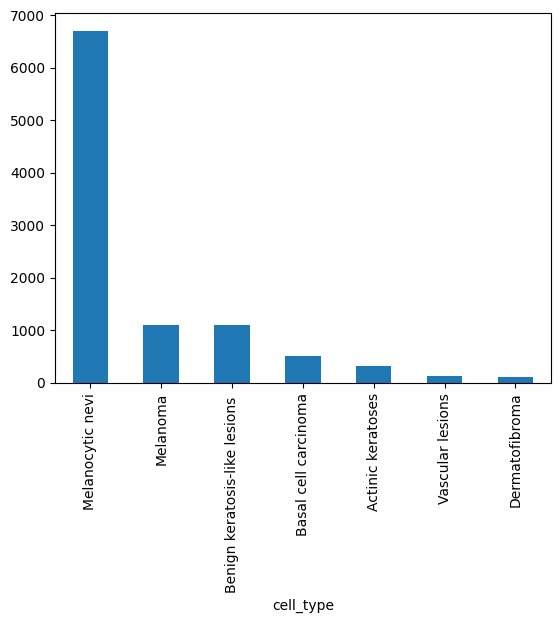

In [39]:
skin_df['cell_type'].value_counts().plot(kind='bar')

**There is a clear 'Class Imbalance' in this dataset!**

<Axes: xlabel='localization'>

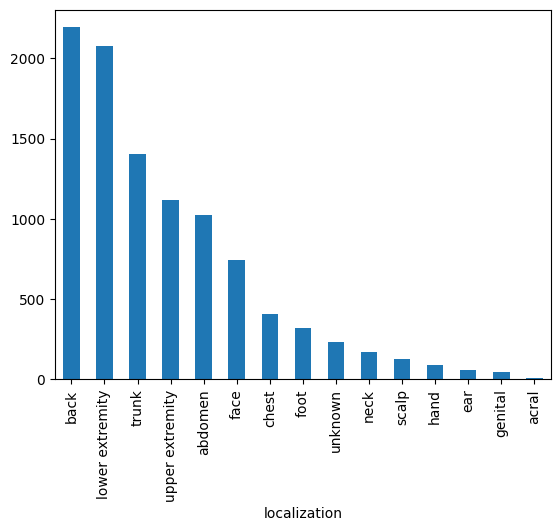

In [40]:
skin_df['localization'].value_counts().plot(kind='bar')

Plotting of Technical Validation field (ground truth), 'dx_type', to see the distribution of its 4 categories:
1. **Histopathology(Histo)**: Histopathologic diagnoses of excised lesions have been performed by specialized dermatopathologists.
2. **Confocal**: Reflectance confocal microscopy is an in-vivo imaging technique with a resolution at near-cellular level , and some facial benign with a grey-world assumption of all training-set images in Lab-color space before and after manual histogram changes.
3. **Follow-up**: If nevi monitored by digital dermatoscopy did not show any changes during 3 follow-up visits or 1.5 years biologists accepted this as evidence of biologic benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions.
4. **Consensus**: For typical benign cases without histopathology or followup biologists provide an expert-consensus rating of authors PT and HK. They applied the consensus label only if both authors independently gave the same unequivocal benign diagnosis. Lesions with this type of groundtruth were usually photographed for educational reasons and did not need further follow-up or biopsy for confirmation.

<Axes: xlabel='dx_type'>

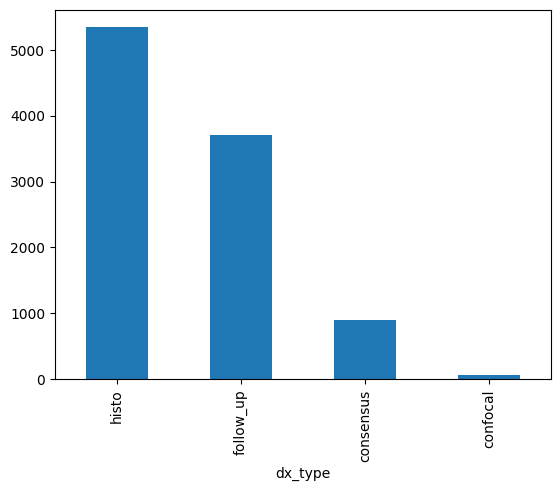

In [41]:
skin_df['dx_type'].value_counts().plot(kind='bar')

In [25]:
skin_df[skin_df['age'] == 0].shape

(39, 11)

In [12]:
skin_df[skin_df['age'] == 0]['dx']

117      bkl
118      bkl
865      bkl
866      bkl
902      bkl
2388    vasc
2389    vasc
2398    vasc
2399    vasc
6683      nv
6684      nv
6860      nv
6861      nv
7499      nv
7500      nv
8016      nv
8017      nv
9218      nv
9219      nv
9232      nv
9233      nv
9234      nv
9235      nv
9242      nv
9243      nv
9302      nv
9303      nv
9329      nv
9346      nv
9347      nv
9356      nv
9357      nv
9371      nv
9372      nv
9375      nv
9377      nv
9378      nv
9633      nv
9634      nv
Name: dx, dtype: object

Now this is a **dataset collection error (probably) where age is zero!** These above records may be dropped out if 'age' is also considered as a crucial factor in the task at hand or replaced by some value after analysis of data. Otherwise, only classification is the main task, then these values may be kept.

<Axes: xlabel='sex'>

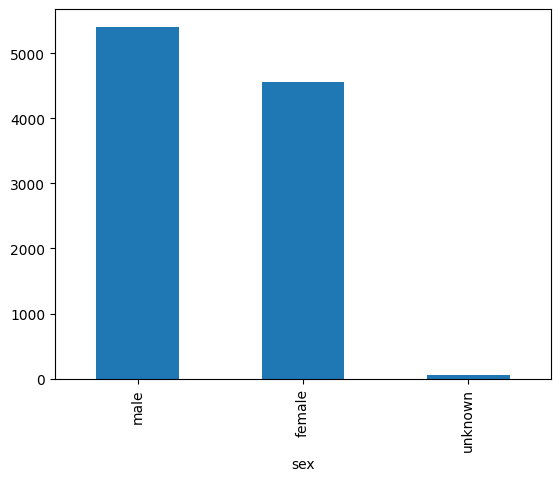

In [26]:
skin_df['sex'].value_counts().plot(kind='bar')

## 5. Preprocessing, Dataloaders & Mixup

In [19]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2


### 5.1 Dataframe with only images and labels

In [9]:
class_mapping = {label: idx for idx, label in enumerate(skin_df['dx'].unique())}
skin_df['label'] = skin_df['dx'].map(class_mapping)

In [10]:
df_img_label = skin_df[['path', 'label']]
df_img_label.head()

,path,label
0,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0
1,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0
2,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0
3,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0
4,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0


**SPLIT data into 3 sets:**

In [11]:
# Splitting into Train, Validation and Test (70:15:15)
train_df, rem_df = train_test_split(df_img_label, test_size=0.3, 
                                    stratify=df_img_label['label'], random_state=42)
val_df, test_df = train_test_split(rem_df, test_size=0.5, stratify=rem_df['label'],
                                  random_state=42)

**Calculting Mean and Std for HAM10000 for normalization**

In [19]:
# # Mean and std channelwise??

# # Define a transform that only converts to tensor (without normalization)
# transform = v2.Compose([
#     v2.PILToTensor(),
#     v2.Resize(size=(resized, resized)), 
#     v2.ToDtype(torch.float32)
# ])

# # Load the dataset (ensure path_to_HAM10000 points to the dataset directory)
# temp_dataset = datasets.ImageFolder(root='/kaggle/working/data', transform=transform)
# temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)

# # Initialize sum and squared sum variables
# mean = torch.zeros(3)  # For 3 channels: R, G, B
# std = torch.zeros(3)
# num_pixels = 0

# # Calculate the mean and standard deviation for each channel
# for images, _ in temp_loader:
#     # Flatten each image to (batch_size, 3, H * W)
#     batch_pixels = images.size(0) * images.size(2) * images.size(3)
#     num_pixels += batch_pixels
    
#     # Sum of means across all batches
#     mean += images.mean([0, 2, 3]) * batch_pixels
#     std += images.std([0, 2, 3]) * batch_pixels

# # Final mean and std over all images
# mean /= num_pixels
# std /= num_pixels

# print("Mean:", mean)
# print("Std:", std)


Mean: tensor([194.7037, 139.2672, 145.4902])
Std: tensor([33.5904, 38.1428, 42.3377])


### 5.2 Transform, Custom Dataset and Dataloaders

In [12]:
# Mean and Std values are taken considering WHOLE DATASET
preproc = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.PILToTensor(),
    v2.Resize(size=(resized, resized)),  # Resize to 'resized'x'resized' Pixels 
    v2.ToDtype(torch.float32),  # to float32, Don't scale
    v2.Normalize(mean=(194.704, 139.267, 145.490), std=(33.590, 38.143, 42.338))  #cal. from HAM10K
])

In [13]:
# Custom Dataset
class SkinLesionDataset():
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        label = self.dataframe.iloc[idx]['label']
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [14]:
train_dataset = SkinLesionDataset(train_df, transform=preproc)
val_dataset = SkinLesionDataset(val_df, transform=preproc)
test_dataset = SkinLesionDataset(test_df, transform=preproc)

# DataLoaders
# bs = 32    ## instantiated above in Section 3
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

dataloaders = {
    "train": train_loader, "val": val_loader, "test": test_loader
}

In [15]:
# One-hot embedding function (explicit), if needed
def one_hot_embedding(labels, num_classes=10):
    y = torch.eye(num_classes).to(device)
    return y[labels]

### 5.3 Mixup Augmentation

In [16]:
# Hyperparameter
mixup_alpha = 1.0  # alpha (default 1.0) is hyperparameter of Beta dist.

In [19]:
# mixup = v2.MixUp(alpha=mixup_alpha, num_classes=7)  ## DIRTECT LIB USE

In [17]:
def mixup_data(x, y, alpha=mixup_alpha, num_classes=7, device=device):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    indices = list(range(batch_size))
    while True:
        random.shuffle(indices)
        # Check if the shuffled indices are a derangement
        if all(i != indices[i] for i in range(batch_size)):
            break
    
    indices = torch.tensor(indices).to(device)
    
    mixed_x = lam * x + (1 - lam) * x[indices, :]
    y_i, y_j = y, y[indices]
    y_i = F.one_hot(y_i, num_classes=num_classes)
    y_j = F.one_hot(y_j, num_classes=num_classes)
    
    return mixed_x, y_i, y_j, lam

In [11]:
# # test FUNCTIONING of Mixup
# for idx, (inputs, labels) in enumerate(train_loader):
#     inputs, labels = inputs.to(device), labels.to(device)
#     mixed_x, y_i, y_j, lam = mixup_data(inputs, labels)
#     print(mixed_x.shape)
#     print(y_i)
# #     print(y_j)
#     break

## 6. Model Architectures, Loss functions and Optimizers
Try pretrained VGG, ResNet, EfficientNet etc. for classification

In [18]:
# ResNet18 architecture with EDL
class EDL_ResNet(nn.Module):
    def __init__(self, num_classes=7, pretrained=True):
        super(EDL_ResNet, self).__init__()
        
        # Load the pretrained ResNet18 model
        self.resnet = tv.models.resnet18(pretrained=pretrained)
        
        # Freeze initial layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace final fully connected layer with a new one for EDL
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        self.softplus = nn.Softplus()  

    def forward(self, x):
        x = self.resnet(x)
        evidences = self.softplus(x)  # Convert to non-negative evidence
        return evidences

In [19]:
# Load ResNet50
resnet50 = tv.models.resnet50(pretrained=True)

# Load VGG16
vgg16 = tv.models.vgg16(pretrained=True)

# Load VGG19
# vgg19 = tv.models.vgg19(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [20]:
def freeze_layers(model, num_layers_to_freeze):
    for i, child in enumerate(model.children()):
        if i < num_layers_to_freeze:
            for param in child.parameters():
                param.requires_grad = False

In [21]:
# ResNet50, VGG16, VGG19 architecture with EDL
class EDL_model_based(nn.Module):
    def __init__(self, model, num_layers_to_freeze, num_classes=7, pretrained=True):
        super(EDL_model_based, self).__init__()
        self.model = model
        
        # Freeze initial layers
        freeze_layers(model, num_layers_to_freeze)
        
        # Replace final fully connected layer with a new one for EDL
        if model == resnet50:
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        else:
            model.classifier[num_layers_to_freeze + 1] = nn.Linear(model.classifier[num_layers_to_freeze + 1].in_features, num_classes)

        self.softplus = nn.Softplus()  

    def forward(self, x):
        x = self.model(x)
        evidences = self.softplus(x)  # Convert to non-negative evidence
        return evidences

In [ ]:
# def kl_divergence(alpha, num_classes, device=None):

#     ones = torch.ones([1, num_classes], dtype=torch.float32, device=device)
#     sum_alpha = torch.sum(alpha, dim=1, keepdim=True)

#     first_term = (
#         torch.lgamma(sum_alpha)
#         - torch.lgamma(alpha).sum(dim=1, keepdim=True)
#         + torch.lgamma(ones).sum(dim=1, keepdim=True)
#         - torch.lgamma(ones.sum(dim=1, keepdim=True))
#     )

#     second_term = (
#         (alpha - ones)
#         .mul(torch.digamma(alpha) - torch.digamma(sum_alpha))
#         .sum(dim=1, keepdim=True)
#     )

#     kl = first_term + second_term
#     return kl


In [ ]:
# def edl_loss(func, y, alpha, epoch_num, num_classes, annealing_step, device=device):
#     y = y.to(device)          # One-hot encoded label vector
#     alpha = alpha.to(device)
#     S = torch.sum(alpha, dim=1, keepdim=True)

#     A = torch.sum(y * (func(S) - func(alpha)), dim=1, keepdim=True)      # Loss eqn (4) of Vanilla-EDL

#     annealing_coef = torch.min(                                          # kl_weight parameter
#         torch.tensor(1.0, dtype=torch.float32),
#         torch.tensor(epoch_num / annealing_step, dtype=torch.float32),
#     )

#     kl_alpha = (alpha - 1) * (1 - y) + 1   #<--------------------
#     kl_div = annealing_coef * kl_divergence(kl_alpha, num_classes, device=device)
#     return A + kl_div

# def edl_digamma_loss(
#     output, target, epoch_num, num_classes, annealing_step, device=None):
#     if not device:
#         device = get_device()

#     evidence = relu_evidence(output)
#     alpha = evidence + 1
#     loss = torch.mean(
#         edl_loss(
#             torch.digamma, target, alpha, epoch_num, num_classes, annealing_step, device
#         )
#     )
#     return loss

In [15]:
# # Digamma Loss with KL Divergence
# class DigammaLoss_and_KL(nn.Module):
#     def __init__(self, num_classes, kl_weight=0.001):
#         super(DigammaLoss_and_KL, self).__init__()
#         self.num_classes = num_classes
#         self.kl_weight = kl_weight

#     def forward(self, evidences, labels):
#         alpha = evidences + 1  # Convert evidence to Dirichlet parameters
#         S = torch.sum(alpha, dim=1, keepdim=True)
#         probs = alpha / S
        
#         # Digamma Loss
#         label_one_hot = F.one_hot(labels, num_classes=self.num_classes).float()
# #         digamma_loss = torch.mean(torch.sum((label_one_hot - probs) * (torch.digamma(S) - torch.digamma(alpha)), dim=1))
#         digamma_loss = torch.mean(torch.sum(label_one_hot * (torch.digamma(S) - torch.digamma(alpha)), dim=1))  # Loss eqn (4) of Vanilla-EDL


#         # KL Divergence Regularization
#         kl_term = kl_divergence(Dirichlet(alpha), Dirichlet(torch.ones_like(alpha)))
#         kl_loss = torch.mean(kl_term)
        
#         return digamma_loss + self.kl_weight * kl_loss

### KL Divergence and Digamma loss

In [22]:
# Digamma Loss with KL Divergence

# USING y_ij = y_i + y_j, labels here is a tuple
def KL_divergence(evidences, labels_list, is_mixup):
    alpha = evidences + 1           # Concentration Parameter (of Dirichlet) 
    if is_mixup:
        y_i, y_j = labels_list[0], labels_list[1]
    
        y_ij = (y_i + y_j).float()
        # If y_i and y_j are of SAME CLASS, then set y_ij to ONE-HOT ENCODED AGAIN
        equal_mask = (y_i == y_j).all(dim=1)
        for idx in range(equal_mask.size(0)):
            if equal_mask[idx]:
                y_ij[idx] /= 2
            
        y_ij = y_ij.to(torch.int64)
        
        alpha_tilde = y_ij + (1 - y_ij) * alpha    # MODIFIED ALPHA
        kl_term = kl_divergence(Dirichlet(alpha_tilde), Dirichlet(torch.ones_like(alpha)))
        kl_loss = torch.mean(kl_term)
    
        return kl_loss
    
    else:
        labels = labels_list[0]
        # ONE-HOT ENCODING OF LABELS 
        labels = F.one_hot(labels, num_classes=alpha.size(1))
        alpha_tilde = labels + (1 - labels) * alpha   # MODIFIED ALPHA
        kl_term = kl_divergence(Dirichlet(alpha_tilde), Dirichlet(torch.ones_like(alpha)))
        kl_loss = torch.mean(kl_term)
    
        return kl_loss

class edl_digamma_loss(nn.Module):
    def __init__(self, annealing_step=10, num_classes=7, name="digamma"):
        super(edl_digamma_loss, self).__init__()
        
        self.annealing_step = annealing_step
        self.num_classes = num_classes
        self.name = name
        
    def forward(self, evidences, label, labels_list, epoch_num, is_mixup=False):
        # label is either y_i or y_j and labels_list is list of these two
        if is_mixup:
            label_one_hot = label
        else:
            label_one_hot = F.one_hot(label, num_classes=self.num_classes).float()  ## index tensor error!!
        #     label_one_hot = one_hot_embedding(label, self.num_classes)
        
        alpha = evidences + 1
        S = torch.sum(alpha, dim=1, keepdim=True)
#         print("size of S", S.size())
        
        digamma_loss = torch.mean(torch.sum(label_one_hot * (torch.digamma(S) - torch.digamma(alpha)), dim=1))  # Loss eqn (4) of Vanilla-EDL
        
        annealing_coef = torch.min(                                        # kl_weight parameter
            torch.tensor(1.0, dtype=torch.float32),
            torch.tensor(epoch_num / self.annealing_step, dtype=torch.float32),
        )
        
        kl_loss = KL_divergence(evidences, labels_list, is_mixup)
        
        return digamma_loss + annealing_coef * kl_loss

### MSE loss function

In [23]:
class edl_mse_loss(nn.Module):
    def __init__(self, annealing_step=10, num_classes=7, name="mse"):
        super(edl_mse_loss, self).__init__()
        
        self.num_classes = num_classes
        self.annealing_step = annealing_step
        self.name = name

    def loglikelihood_loss(self, label_one_hot, alpha):
        label_one_hot = label_one_hot.to(device)
        alpha = alpha.to(device)
        S = torch.sum(alpha, dim=1, keepdim=True)
        loglikelihood_err = torch.sum((label_one_hot - (alpha / S)) ** 2, dim=1, keepdim=True)
        loglikelihood_var = torch.sum(alpha * (S - alpha) / (S * S * (S + 1)), dim=1, keepdim=True)
        loglikelihood = loglikelihood_err + loglikelihood_var
        return torch.mean(loglikelihood)

    def forward(self, evidences, label, labels_list, epoch_num, is_mixup=False):
        label = label.to(device)
        alpha = (evidences + 1).to(device)
        
        if is_mixup:
            label_one_hot = label
        else:
            label_one_hot = F.one_hot(label, num_classes=self.num_classes).float()  ## index tensor error!!
        #     label_one_hot = one_hot_embedding(label, self.num_classes)
        
        loglikelihood = self.loglikelihood_loss(label_one_hot, alpha)
        
        annealing_coef = torch.min(
            torch.tensor(1.0, dtype=torch.float32),
            torch.tensor(epoch_num / self.annealing_step, dtype=torch.float32)
        )

#         kl_alpha = (alpha - 1) * (1 - y) + 1
        kl_loss = KL_divergence(evidences, labels_list, is_mixup)
        
        return loglikelihood + annealing_coef * kl_loss


**Testing the working of code after getting y_ij and alpha_tilde**

one change made to y_ij -> dtype converted to float32 then converted back to int64

In [83]:
# for idx, (inputs, labels) in enumerate(train_loader):
#     inputs, labels = inputs.to(device), labels.to(device)
#     inputs, y_i, y_j, lam = mixup_data(inputs, labels)
#     evidences = edl_resnet_model(inputs)
#     alpha = evidences + 1
#     y_ij = (y_i + y_j).float()
#     # If y_i and y_j are of same class, then set y_ij to one-hot encoded again
#     equal_mask = (y_i == y_j).all(dim=1)
#     print(equal_mask)
#     for idx in range(equal_mask.size(0)):
#         if equal_mask[idx]:
#             y_ij[idx] /= 2
#     y_ij = y_ij.to(torch.int64)
#     print(y_i[:5])
#     print(y_j[:5])
#     print(y_ij[0:5])
#     epsilon = 1e-5  # Small constant to prevent zeros
#     alpha_tilde = y_ij + (1 - y_ij)*alpha + epsilon
#     print(alpha_tilde<0)
# #     print(labels[:10])
#     print(kl_divergence(Dirichlet(alpha_tilde), Dirichlet(torch.ones_like(alpha))))
#     break

tensor([[0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0]])


In [23]:
# temp_alpha = torch.randint(100, (4, 7))
# temp_S = torch.sum(temp_alpha, dim=1, keepdim=True)

In [63]:
# temp_labels = torch.randint(7, (4,))
# label_one_hot = F.one_hot(temp_labels, num_classes=7).float()
# label_one_hot
# # del(label_one_hot)
# # del(temp_labels)

In [38]:
# torch.digamma(temp_S) - torch.digamma(temp_alpha)

tensor([[4.3911, 1.4204, 1.7865, 2.1659, 2.6267, 3.0443, 1.0986],
        [1.3519, 4.6230, 4.9564, 1.8449, 1.5418, 1.4663, 2.1778],
        [1.8012, 1.9786, 1.4149, 2.8066, 2.2959, 2.5703, 1.5700],
        [1.8341, 2.0854, 1.5408, 2.1046, 2.3699, 1.8341, 2.1242]])

In [24]:
num_classes = 7  
annealing_step = 10

# Resenet18
edl_resnet_model = EDL_ResNet(num_classes=num_classes, pretrained=True)
edl_resnet_model = edl_resnet_model.to(device)

# Resnet50
edl_resnet50_model = EDL_model_based(resnet50, 7, num_classes=num_classes, pretrained=True)
edl_resnet50_model = edl_resnet50_model.to(device)

# VGG16
edl_VGG16_model = EDL_model_based(vgg16, 5, num_classes=num_classes, pretrained=True)
edl_VGG16_model = edl_VGG16_model.to(device)

# # VGG19
# edl_VGG19_model = EDL_model_based(vgg19, 5, num_classes=num_classes, pretrained=True)
# edl_VGG19_model = edl_VGG19_model.to(device)

# # Define loss and optimizer
# # criterion_digamma = edl_digamma_loss(annealing_step=annealing_step, num_classes=num_classes)   # If use Digamma loss
#                                          #OR
criterion_mse = edl_mse_loss(annealing_step=annealing_step, num_classes=num_classes)   # If use MSE loss

# # optimizer_resnet = torch.optim.Adam(filter(lambda p: p.requires_grad, edl_resnet_model.parameters()), lr=0.001)
optimizer_resnet50 = torch.optim.Adam(filter(lambda p: p.requires_grad, edl_resnet50_model.parameters()), lr=0.001)
optimizer_VGG16 = torch.optim.Adam(filter(lambda p: p.requires_grad, edl_VGG16_model.parameters()), lr=0.001)
# optimizer_VGG19 = torch.optim.Adam(filter(lambda p: p.requires_grad, edl_VGG19_model.parameters()), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


## 7. Training

### 7.1 Without mixup

**Classification based on logits**

In [30]:
# Set the NUMBER OF Epochs (hyperparam)
num_epochs = 30

def train_model(
    model,
    dataloaders,
    num_classes,
    criterion,
    optimizer,
    num_epochs=num_epochs,
    device=device,
    uncertainty=False,
):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    losses = {"loss": [], "phase": [], "epoch": []}
    accuracy = {"accuracy": [], "phase": [], "epoch": []}
    evidences = {"evidence": [], "type": [], "epoch": []}

    for epoch in range(num_epochs):
        print("\nEpoch {}/{} :".format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                print("'\033[1m' Training with {} loss...".format(criterion.name))
                model.train()  
            else:
                print("Validating...")
                model.eval()  

            running_loss = 0.0
            running_corrects = 0.0
            correct = 0

            # Iterate
            for i, (inputs, labels) in enumerate(dataloaders[phase]):

                inputs, labels = inputs.to(device), labels.to(device)
                labels_list = [labels]   # Not needed in case of NO Mixup, just optionally providing for digamma fn

                optimizer.zero_grad()

                # track train phase
                with torch.set_grad_enabled(phase == "train"):

                    if uncertainty:
                        evidences = model(inputs)
                        alpha = evidences + 1
                        S = torch.sum(alpha, dim=1, keepdim=True)   # Dirichlet Strength
                        
                        # Estimated probabilities and Predictions
                        est_probabilities = alpha/S  # <----------
                        _, preds = torch.max(evidences, 1)

                        # LOSS calculated using above defined LOSS function
#                         print("labels shape = ", labels.shape)
#                         print("alpha shape = ", alpha.shape)
                        loss = criterion.forward(evidences, labels, labels_list, epoch, is_mixup=False)

                        match = torch.reshape(torch.eq(preds, labels).float(), (-1, 1))  # preds == labels ?? -> One-hot encoded matching
                        acc = torch.mean(match)  
                        
                        # Uncertainty Calculation
                        u = num_classes / torch.sum(alpha, dim=1, keepdim=True)

#                         total_evidence = torch.sum(evidences, 1, keepdim=True)
#                         mean_evidence = torch.mean(total_evidence)
#                         mean_evidence_succ = torch.sum(
#                             torch.sum(evidences, 1, keepdim=True) * match
#                         ) / torch.sum(match + 1e-20)
#                         mean_evidence_fail = torch.sum(
#                             torch.sum(evidences, 1, keepdim=True) * (1 - match)
#                         ) / (torch.sum(torch.abs(1 - match)) + 1e-20)

                    else:
                        evidences = model(inputs)
                        S = torch.sum((evidences + 1), dim=1, keepdim=True)   
                        
                        # Estimated probabilities and Predictions
                        est_probabilities = (evidences + 1)/S  # <----------
                        _, preds = torch.max(evidences, 1)
                        
                        # LOSS calculated using above defined LOSS function
                        loss = criterion.forward(evidences, labels, labels_list, epoch, is_mixup=False)
                        
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # stats (don't forget to extract python number from torch.tensor in loss and accuracy)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            losses["loss"].append(epoch_loss)
            losses["phase"].append(phase)
            losses["epoch"].append(epoch)
            accuracy["accuracy"].append(epoch_acc.item())
            accuracy["epoch"].append(epoch)
            accuracy["phase"].append(phase)

            print(
                "{} loss: {:.4f} acc: {:.4f}".format(
                    phase.capitalize(), epoch_loss, epoch_acc
                )
            )
            
            print("-"*10)
            
            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            # Checkpoints after every 10 epochs
            if (epoch+1) < num_epochs and (epoch+1) % 10 == 0:
                checkpoints_edl_digamma = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "metrics": (losses, accuracy)
                }
                
                if model == edl_resnet_model:
                    torch.save(checkpoints_edl_digamma, "/kaggle/working/model_uncertainty_{}_EPOCH{}.pt".format(criterion.name, epoch))
                elif model == edl_resnet50_model:
                    torch.save(checkpoints_edl_digamma, "/kaggle/working/resnet50_uncertainty_{}_EPOCH{}.pt".format(criterion.name, epoch))
                elif model == edl_VGG16_model:
                    torch.save(checkpoints_edl_digamma, "/kaggle/working/VGG16_uncertainty_{}_EPOCH{}.pt".format(criterion.name, epoch))
                else:
                    torch.save(checkpoints_edl_digamma, "/kaggle/working/VGG19_uncertainty_{}_EPOCH{}.pt".format(criterion.name, epoch))

            


    time_elapsed = time.time() - since

    print(
        "\nTraining complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    
    print("Best val Acc: {:4f}".format(best_acc))
    
    # Save the losses and accuracy as metrics
    metrics = (losses, accuracy)
    
    # SAVE the Model
    state_edl_digamma = {
            "epochs": num_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "metrics": metrics
        }

    if model == edl_resnet_model:
        torch.save(state_edl_digamma, "/kaggle/working/model_uncertainty_{}.pt".format(criterion.name))
        print("Model edl_resnet_model Saved!")
    elif model == edl_resnet50_model:
        torch.save(state_edl_digamma, "/kaggle/working/resnet50_uncertainty_{}.pt".format(criterion.name))
        print("Model edl_resnet50_model Saved!")
    elif model == edl_VGG16_model:
        torch.save(state_edl_digamma, "/kaggle/working/VGG16_uncertainty_{}.pt".format(criterion.name))
        print("Model edl_VGG16_model Saved!")
    else:
        torch.save(state_edl_digamma, "/kaggle/working/VGG19_uncertainty_{}.pt".format(criterion.name))
        print("Model edl_VGG19_model Saved!")

    return model, metrics

### EDL with pre-trained ResNet50

In [36]:
## Digamma loss
# edl_digamma_resnet50_model,digamma_resnet50_metrics = train_model(edl_resnet50_model, dataloaders, num_classes, criterion_digamma, optimizer_resnet50, num_epochs, device, uncertainty=True)
                                                               
                                                                    ## OR
        
## MSE loss
edl_mse_resnet50_model,mse_resnet50_metrics = train_model(edl_resnet50_model, dataloaders, num_classes, criterion_mse, optimizer_resnet50, num_epochs, device, uncertainty=True)


Epoch 0/29 :
'' Training with mse loss...
Train loss: 0.4127 acc: 0.7211
----------
Validating...
Val loss: 0.3500 acc: 0.7630
----------

Epoch 1/29 :
'' Training with mse loss...
Train loss: 0.4572 acc: 0.7603
----------
Validating...
Val loss: 0.4370 acc: 0.7603
----------

Epoch 2/29 :
'' Training with mse loss...
Train loss: 0.4485 acc: 0.7924
----------
Validating...
Val loss: 0.4670 acc: 0.7776
----------

Epoch 3/29 :
'' Training with mse loss...
Train loss: 0.4397 acc: 0.8123
----------
Validating...
Val loss: 0.5093 acc: 0.7803
----------

Epoch 4/29 :
'' Training with mse loss...
Train loss: 0.4202 acc: 0.8312
----------
Validating...
Val loss: 0.5138 acc: 0.7850
----------

Epoch 5/29 :
'' Training with mse loss...
Train loss: 0.4118 acc: 0.8405
----------
Validating...
Val loss: 0.5776 acc: 0.7949
----------

Epoch 6/29 :
'' Training with mse loss...
Train loss: 0.4065 acc: 0.8456
----------
Validating...
Val loss: 0.5907 acc: 0.7883
----------

Epoch 7/29 :
'' Training w

### Training EDL with pre-trained VGG16

In [39]:
# ## Digamma loss
# # edl_digamma_VGG16_model,digamma_VGG16_metrics = train_model(edl_VGG16_model, dataloaders, num_classes, criterion_digamma, optimizer_VGG16, num_epochs, device, uncertainty=True)
                                                               
#                                                                     ## OR
        
# ## MSE loss
edl_mse_VGG16_model,mse_VGG16_metrics = train_model(edl_VGG16_model, dataloaders, num_classes, criterion_mse, optimizer_VGG16, num_epochs, device, uncertainty=True)


Epoch 0/29 :
'' Training with mse loss...
Train loss: 0.4640 acc: 0.6863
----------
Validating...
Val loss: 0.4176 acc: 0.7057
----------

Epoch 1/29 :
'' Training with mse loss...
Train loss: 0.5606 acc: 0.7136
----------
Validating...
Val loss: 0.5230 acc: 0.7290
----------

Epoch 2/29 :
'' Training with mse loss...
Train loss: 0.5783 acc: 0.7244
----------
Validating...
Val loss: 0.5688 acc: 0.7317
----------

Epoch 3/29 :
'' Training with mse loss...
Train loss: 0.6099 acc: 0.7257
----------
Validating...
Val loss: 0.5910 acc: 0.7237
----------

Epoch 4/29 :
'' Training with mse loss...
Train loss: 0.6349 acc: 0.7285
----------
Validating...
Val loss: 0.6290 acc: 0.7277
----------

Epoch 5/29 :
'' Training with mse loss...
Train loss: 0.6575 acc: 0.7258
----------
Validating...
Val loss: 0.6330 acc: 0.7290
----------

Epoch 6/29 :
'' Training with mse loss...
Train loss: 0.6666 acc: 0.7205
----------
Validating...
Val loss: 0.6535 acc: 0.7304
----------

Epoch 7/29 :
'' Training w

### Training EDL with pre-trained VGG19

In [40]:
# ## Digamma loss
# # edl_digamma_VGG19_model,digamma_VGG19_metrics = train_model(edl_VGG19_model, dataloaders, num_classes, criterion_digamma, optimizer_VGG19, num_epochs, device, uncertainty=True)
                                                               
#                                                                     ## OR
        
# ## MSE loss
edl_mse_VGG19_model,mse_VGG19_metrics = train_model(edl_VGG19_model, dataloaders, num_classes, criterion_mse, optimizer_VGG19, num_epochs, device, uncertainty=True)


Epoch 0/29 :
'' Training with mse loss...
Train loss: 0.4705 acc: 0.6896
----------
Validating...
Val loss: 0.4177 acc: 0.6997
----------

Epoch 1/29 :
'' Training with mse loss...
Train loss: 0.5691 acc: 0.7111
----------
Validating...
Val loss: 0.5297 acc: 0.7117
----------

Epoch 2/29 :
'' Training with mse loss...
Train loss: 0.5952 acc: 0.7170
----------
Validating...
Val loss: 0.5788 acc: 0.7190
----------

Epoch 3/29 :
'' Training with mse loss...
Train loss: 0.6212 acc: 0.7188
----------
Validating...
Val loss: 0.5964 acc: 0.7190
----------

Epoch 4/29 :
'' Training with mse loss...
Train loss: 0.6437 acc: 0.7185
----------
Validating...
Val loss: 0.6191 acc: 0.7077
----------

Epoch 5/29 :
'' Training with mse loss...
Train loss: 0.6675 acc: 0.7133
----------
Validating...
Val loss: 0.6355 acc: 0.7071
----------

Epoch 6/29 :
'' Training with mse loss...
Train loss: 0.6810 acc: 0.7133
----------
Validating...
Val loss: 0.6456 acc: 0.7130
----------

Epoch 7/29 :
'' Training w

### 7.2 Training with mixup
* Loss function and Regularizer are modified because of mixup technique

In [25]:
def mixup_criterion(criterion, evidences, y_i, y_j, lam, epoch_num):
    labels_list = [y_i, y_j]
    return lam * criterion.forward(evidences, y_i, labels_list, epoch_num, is_mixup=True) \
            + (1 - lam) * criterion.forward(evidences, y_j, labels_list, epoch_num, is_mixup=True)

In [45]:
# Set the NUMBER OF Epochs (hyperparam)
num_epochs = 30

# MIXUP WITH ALPHA TILDE used in KL
def train_model_mixup(
    model,
    dataloaders,
    num_classes,
    criterion,             # criterion is either criterion_digamma or criterion_mse
    optimizer,
    mixup_alpha=mixup_alpha,
    num_epochs=num_epochs,
    device=device,
    uncertainty=False,
    logits=True
):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc_mixup = 0.0

    losses = {"loss": [], "phase": [], "epoch": []}
    accuracy = {"accuracy": [], "phase": [], "epoch": []}
    evidences = {"evidence": [], "type": [], "epoch": []}

    for epoch in range(num_epochs):
        print("\nEpoch {}/{} :".format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                print("'\033[1m' Training using {} loss...".format(criterion.name))
                model.train()  
            else:
                print("Validating...")
                model.eval()  

            running_loss = 0.0
            running_corrects = 0.0
            correct = 0

            for i, (inputs, labels) in enumerate(dataloaders[phase]):
#                 if epoch == 0:
#                     print("label shape before mixup", labels.shape)
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Perform augmentation on data
                inputs, labels_i, labels_j, lam = mixup_data(inputs, labels, mixup_alpha, num_classes, device)
#                 labels = labels.long()    # tensors used as indices must be long/int/byte/bool tensors
                inputs, labels_i, labels_j = map(Variable, (inputs, labels_i, labels_j))
                
#                 if epoch == 0 and correct ==0:                         # To Check shapes
#                     print("Size of input after mixup:", inputs.shape)
#                     print("Size of labels after mixup:", labels.shape)
#                     print("Size of y_i after mixup:", labels_i.shape)
# #                     print("y_i: ", y_i)
# #                     print("y_j: ", y_j)
                
                optimizer.zero_grad()

                # track train phase
                with torch.set_grad_enabled(phase == "train"):

                    if uncertainty:
                        evidences = model(inputs)
                        alpha = evidences + 1
                        S = torch.sum(alpha, dim=1, keepdim=True)   # Dirichlet Strength
                        
                        # Estimated probabilities and Predictions
                        est_probabilities = alpha/S  # <--------------------------------
                        outputs = [evidences, est_probabilities]
                        if logits:
                            _, preds = torch.max(outputs[0], 1) #<-----LOGITS USED
                        else:
                            _, preds = torch.max(outputs[1], 1) #<-----Est_prob. Used
                        
                        # LOSS calculated using above defined LOSS function
                        loss = mixup_criterion(criterion, evidences, labels_i, labels_j, lam, epoch)
                        
                        # running corrects
#                         match = torch.reshape(torch.eq(preds, labels).float(), (-1, 1))  # preds == labels ?? -> One-hot encoded matching
#                         acc = torch.mean(match)
                                                # OR
                        labels_i_class = torch.argmax(labels_i, dim=1)
                        labels_j_class = torch.argmax(labels_j)
#                         if epoch == 0 and correct ==0:             ## to check shapes
#                             print("labels_i_class", labels_i_class)
                        correct += (lam * preds.eq(labels_i_class).cpu().sum().float() \
                                    + (1 - lam) * preds.eq(labels_j_class).cpu().sum().float())
                        running_corrects += correct
#                         acc = currect/labels.size(0)
        
                        # Uncertainty Calculation
                        u = num_classes / torch.sum(alpha, dim=1, keepdim=True)

#                         total_evidence = torch.sum(evidences, 1, keepdim=True)
#                         mean_evidence = torch.mean(total_evidence)
#                         mean_evidence_succ = torch.sum(
#                             torch.sum(evidences, 1, keepdim=True) * match
#                         ) / torch.sum(match + 1e-20)
#                         mean_evidence_fail = torch.sum(
#                             torch.sum(evidences, 1, keepdim=True) * (1 - match)
#                         ) / (torch.sum(torch.abs(1 - match)) + 1e-20)

                    else:
                        evidences = model(inputs)
                        S = torch.sum((evidences + 1), dim=1, keepdim=True)   

                        _, preds = torch.max(evidences, 1)
                        
                        # running corrects
                        labels_i_class = torch.argmax(labels_i, dim=1)
                        labels_j_class = torch.argmax(labels_j, dim=1)
                        correct += (lam * preds.eq(labels_i_class).cpu().sum().float() \
                                    + (1 - lam) * preds.eq(labels_j_class).cpu().sum().float())
                        running_corrects += correct
                        
                        # LOSS calculated using above defined LOSS function
                        loss = mixup_criterion(criterion, evidences, labels_i, labels_j, lam, epoch)
                        
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # stats (don't forget to extract python number from torch.tensor in loss and accuracy)
                running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            losses["loss"].append(epoch_loss)
            losses["phase"].append(phase)
            losses["epoch"].append(epoch)
            accuracy["accuracy"].append(epoch_acc.item())
            accuracy["epoch"].append(epoch)
            accuracy["phase"].append(phase)

            print(
                "{} loss: {:.4f} acc: {:.4f}".format(
                    phase.capitalize(), epoch_loss, epoch_acc
                )
            )
            
            print("-"*10)
            
            # deep copy the model
            if phase == "val" and epoch_acc > best_acc_mixup:
                best_acc_mixup = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            # Checkpoints after every 10 epochs
            if (epoch+1) < num_epochs and (epoch+1) % 10 == 0:
                checkpoints_edl_digamma = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "metrics": (losses, accuracy)
                }

                if model == edl_resnet_model:
                    torch.save(checkpoints_edl_digamma, "/kaggle/working/model_uncertainty_{}_MIXUP_EPOCH{}.pt".format(criterion.name, epoch))
                elif model == edl_resnet50_model:
                    torch.save(checkpoints_edl_digamma, "/kaggle/working/resnet50_uncertainty_{}_MIXUP_EPOCH{}.pt".format(criterion.name, epoch))
                elif model == edl_VGG16_model:
                    torch.save(checkpoints_edl_digamma, "/kaggle/working/VGG16_uncertainty_{}_MIXUP_EPOCH{}.pt".format(criterion.name, epoch))
                else:
                    torch.save(checkpoints_edl_digamma, "/kaggle/working/VGG19_uncertainty_{}_MIXUP_EPOCH{}.pt".format(criterion.name, epoch))



    time_elapsed = time.time() - since

    print(
        "\nTraining complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    
    print("Best val Acc (Mixup): {:4f}".format(best_acc_mixup))
    
    # Save the losses and accuracy as metrics
    metrics = (losses, accuracy)
    
    # SAVE the Model
    state_edl_digamma = {
            "epochs": num_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "metrics": metrics
        }

    if model == edl_resnet_model:
        torch.save(state_edl_digamma, "/kaggle/working/model_uncertainty_{}_MIXUP.pt".format(criterion.name))
        print("Model edl_resnet_model Saved!")
    elif model == edl_resnet50_model:
        torch.save(state_edl_digamma, "/kaggle/working/resnet50_uncertainty_{}_MIXUP.pt".format(criterion.name))
        print("Model edl_resnet50_model Saved!")
    elif model == edl_VGG16_model:
        torch.save(state_edl_digamma, "/kaggle/working/VGG16_uncertainty_{}_MIXUP.pt".format(criterion.name))
        print("Model edl_VGG16_model Saved!")
    else:
        torch.save(state_edl_digamma, "/kaggle/working/VGG19_uncertainty_{}_MIXUP.pt".format(criterion.name))
        print("Model edl_VGG19_model Saved!")

    return model, metrics

### Training with mixup and Resnet50

**Logits for classification**

In [46]:
## Digamma loss
# edl_digamma_resnet50_model_mixup,digamma_resnet50_metrics_mixup = train_model_mixup(edl_resnet50_model, dataloaders, num_classes, criterion_digamma, optimizer_resnet50, mixup_alpha, num_epochs, device, uncertainty=True, logits=True)
                                                               
                                                                    ## OR
        
## MSE loss
edl_mse_resnet50_model_mixup,mse_resnet50_metrics_mixup = train_model_mixup(edl_resnet50_model, dataloaders, num_classes, criterion_mse, optimizer_resnet50, mixup_alpha, num_epochs, device, uncertainty=True, logits=True)


Epoch 0/29 :
'' Training using mse loss...
Train loss: 0.3481 acc: 72.8747
----------
Validating...
Val loss: 0.4471 acc: 16.5094
----------

Epoch 1/29 :
'' Training using mse loss...
Train loss: 0.3806 acc: 73.6154
----------
Validating...
Val loss: 0.4892 acc: 15.6128
----------

Epoch 2/29 :
'' Training using mse loss...
Train loss: 0.3771 acc: 74.3617
----------
Validating...
Val loss: 0.5421 acc: 16.2509
----------

Epoch 3/29 :
'' Training using mse loss...
Train loss: 0.3794 acc: 74.4025
----------
Validating...
Val loss: 0.5342 acc: 15.7694
----------

Epoch 4/29 :
'' Training using mse loss...
Train loss: 0.3830 acc: 76.3192
----------
Validating...
Val loss: 0.5573 acc: 15.4540
----------

Epoch 5/29 :
'' Training using mse loss...
Train loss: 0.4058 acc: 76.5804
----------
Validating...
Val loss: 0.5897 acc: 14.0901
----------

Epoch 6/29 :
'' Training using mse loss...
Train loss: 0.4048 acc: 75.8479
----------
Validating...
Val loss: 0.6092 acc: 13.7474
----------

Epoch

**Probability estimates for classification**

In [ ]:
## Digamma loss
# edl_digamma_resnet50_model_mixup2,digamma_resnet50_metrics_mixup2 = train_model_mixup(edl_resnet50_model, dataloaders, num_classes, criterion_digamma, optimizer_resnet50, mixup_alpha, num_epochs, device, uncertainty=True, logits=False)
                                                               
                                                                    ## OR
        
## MSE loss
# edl_mse_resnet50_model_mixup2,mse_resnet50_metrics_mixup2 = train_model_mixup(edl_resnet50_model, dataloaders, num_classes, criterion_mse, optimizer_resnet50, mixup_alpha, num_epochs, device, uncertainty=True, logits=False)

### Training With mixup and VGG16

**Logits are used for class predictions:**

In [ ]:
## Digamma loss
# edl_digamma_VGG16_model_mixup,digamma_metrics_VGG16_mixup = train_model_mixup(edl_VGG16_model, dataloaders, num_classes, criterion_digamma, optimizer_VGG16, mixup_alpha, num_epochs, device, uncertainty=True, logits=True)
    
                                                                    ## OR
## MSE loss
# edl_mse_VGG16_model_mixup,mse_metrics_VGG16_mixup = train_model_mixup(edl_VGG16_model, dataloaders, num_classes, criterion_mse, optimizer_VGG16, mixup_alpha, num_epochs, device, uncertainty=True, logits=True)

* **Instead of logits, estimated probabilities are used to predict class (not uncertainty)**

In [ ]:
## Digamma loss
# edl_digamma_VGG16_model_mixup2,digamma_metrics_VGG16_mixup2 = train_model_mixup(edl_VGG16_model, dataloaders, num_classes, criterion_digamma, optimizer_VGG16, mixup_alpha, num_epochs, device, uncertainty=True, logits=False)
    
                                                                    ## OR
## MSE loss
# edl_mse_VGG16_model_mixup2,mse_metrics_VGG16_mixup2 = train_model_mixup(edl_VGG16_model, dataloaders, num_classes, criterion_mse, optimizer_VGG16, mixup_alpha, num_epochs, device, uncertainty=True, logits=False)

### Training With mixup and VGG19

**classification using logits**

In [ ]:
## Digamma loss
# edl_digamma_VGG19_model_mixup,digamma_metrics_VGG19_mixup = train_model_mixup(edl_VGG19_model, dataloaders, num_classes, criterion_digamma, optimizer_VGG19, mixup_alpha, num_epochs, device, uncertainty=True, logits=True)
    
                                                                    ## OR
## MSE loss
# edl_mse_VGG19_model_mixup,mse_metrics_VGG19_mixup = train_model_mixup(edl_VGG19_model, dataloaders, num_classes, criterion_mse, optimizer_VGG19, mixup_alpha, num_epochs, device, uncertainty=True, logits=True)

**classification using estimated probabilities**


In [ ]:
## Digamma loss
# edl_digamma_VGG19_model_mixup2,digamma_metrics_VGG19_mixup2 = train_model_mixup(edl_VGG19_model, dataloaders, num_classes, criterion_digamma, optimizer_VGG19, mixup_alpha, num_epochs, device, uncertainty=True, logits=False)
    
                                                                    ## OR
## MSE loss
# edl_mse_VGG19_model_mixup2,mse_metrics_VGG19_mixup2 = train_model_mixup(edl_VGG19_model, dataloaders, num_classes, criterion_mse, optimizer_VGG19, mixup_alpha, num_epochs, device, uncertainty=True, logits=False)

## 8. Loading Saved model(s)

### 8.1 ResNet50

In [27]:
# LOAD Resnet50 (Without mixup and mse loss) model 
checkpoint = torch.load("/kaggle/input/resnet50_mse/pytorch/default/1/resnet50_uncertainty_mse.pt")

/tmp/ipykernel_30/1148155097.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/resnet50_mse/pytorch/default/1/resnet50_uncertainty_m

In [28]:
edl_resnet50_model.load_state_dict(checkpoint["model_state_dict"])  # Load the final saved model
optimizer_resnet50.load_state_dict(checkpoint["optimizer_state_dict"])

### 8.2 VGG16

In [26]:
# LOAD VGG16 (Without mixup and digamma loss) model 
checkpoint_vgg16 = torch.load("/kaggle/input/vgg16_digamma/pytorch/default/1/VGG16_uncertainty_digamma.pt", map_location = torch.device(device))

/tmp/ipykernel_30/2626615665.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_vgg16 = torch.load("/kaggle/input/vgg16_digamma/pytorch/default/1/VGG16_uncertain

In [27]:
edl_VGG16_model.load_state_dict(checkpoint_vgg16["model_state_dict"])  # Load the final saved model
optimizer_VGG16.load_state_dict(checkpoint_vgg16["optimizer_state_dict"])

### 8.3 Resnet50 + Mixup + mse loss (Load Only When Evaluating/Testing With Mixup Case)

In [26]:
# Load Resnet50 (WITH Mixup and mse loss)
checkpoint_mixup = torch.load("/kaggle/input/resnet50_mse_mixup/pytorch/default/1/resnet50_uncertainty_mse_MIXUP.pt")
edl_resnet50_model.load_state_dict(checkpoint_mixup["model_state_dict"])  # Load the final saved model
optimizer_resnet50.load_state_dict(checkpoint_mixup["optimizer_state_dict"])

/tmp/ipykernel_30/1602539397.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_mixup = torch.load("/kaggle/input/resnet50_mse_mixup/pytorch/default/1/resnet50_u

### 8.4 VGG16 + Mixup + Digamma loss (Load Only When Evaluating/Testing mixup case)

In [60]:
# # LOAD VGG16 (Without mixup and digamma loss) model 
# checkpoint_vgg16 = torch.load("/kaggle/input/vgg16_digamma/pytorch/default/1/VGG16_uncertainty_digamma.pt")
# edl_VGG16_model.load_state_dict(checkpoint_vgg16["model_state_dict"])  # Load the final saved model
# optimizer_VGG16.load_state_dict(checkpoint_vgg16["optimizer_state_dict"])

/tmp/ipykernel_30/3383857680.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_vgg16 = torch.load("/kaggle/input/vgg16_digamma/pytorch/default/1/VGG16_uncertain

## 9. Test the models

In [27]:
for i in range(2):
    images, labels = next(iter(test_loader))
    
    random_idx = random.randint(0, images.size(0) - 1)
    single_image = images[random_idx]  # Select a single image
    single_label = labels[random_idx]
    
    single_image = single_image.to(device).unsqueeze(0)  # Add batch dimension for single image
    print(f"\nSample Image {i+1} - \n")
    print("Original image shape:\n", single_image.shape)
    
    edl_resnet50_model.eval()
    with torch.no_grad():
            evidence = edl_resnet50_model(single_image)
            alpha = evidence + 1
            uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
            _, preds = torch.max(evidence, 1)
            prob = alpha / torch.sum(alpha, dim=1, keepdim=True)   # Estimated Class Probabilities
            evidence = evidence.flatten()
            prob = prob.flatten()
            preds = preds.flatten()
            print("\n \033[1m Probs:", prob)
            print("\n \033[1m Prediction:", preds[0])
            print("\033[1m  Ground truth:", single_label)       
            print("\n \033[1m Uncertainty estimate:", uncertainty, "\033[0m")
    print("."*100)
    print()


Sample Image 1 - 

Original image shape:
 torch.Size([1, 3, 64, 64])

  Probs: tensor([0.0040, 0.9758, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040],
       device='cuda:0')

  Prediction: tensor(1, device='cuda:0')
  Ground truth: tensor(1)

  Uncertainty estimate: tensor([[0.0283]], device='cuda:0') 
....................................................................................................


Sample Image 2 - 

Original image shape:
 torch.Size([1, 3, 64, 64])

  Probs: tensor([0.1498, 0.1421, 0.1417, 0.1416, 0.1416, 0.1416, 0.1416],
       device='cuda:0')

  Prediction: tensor(0, device='cuda:0')
  Ground truth: tensor(0)

  Uncertainty estimate: tensor([[0.9914]], device='cuda:0') 
....................................................................................................



In [28]:
def test_single_image(model, test_loader, uncertainty=True, is_mixup=False, device=device):
    images, labels = next(iter(test_loader))
    
    random_idx = random.randint(0, images.size(0) - 1)
    single_image = images[random_idx]  # Select a single image
    single_label = labels[random_idx]
    
    single_image = single_image.to(device).unsqueeze(0)  # Add batch dimension for single image
    
    lesion_types = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    print("\033[1m Lesion Types: ", lesion_types, "\033[0m")
    
    print("\nOriginal image shape:\n", single_image.shape)
    
    model.eval()
    with torch.no_grad():
        if uncertainty:
            evidence = model(single_image)
            alpha = evidence + 1
            uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
            _, preds = torch.max(evidence, 1)
            prob = alpha / torch.sum(alpha, dim=1, keepdim=True)   # Estimated Class Probabilities
            evidence = evidence.flatten()
            prob = prob.flatten()
            preds = preds.flatten()
            print("\n \033[1m Probs:", prob)
            print("\n \033[1m Prediction: ", preds[0])
            print("\033[1m  Ground truth:", single_label)       
            print("\n \033[1m Uncertainty estimate:", uncertainty, "\033[0m \n")
    
        else:
            output = model(single_image)
            _, preds = torch.max(output, 1)
            prob = F.softmax(output, dim=1)
            output = output.flatten()
            prob = prob.flatten()
            preds = preds.flatten()
            print("\n \033[1m Probs:", prob)
            print("\n \033[1m Prediction:", preds[0])
            print("\033[1m  Ground truth:", single_label) 
            print()

        labels = np.arange(7)
        fig = plt.figure(figsize=[7, 5])
        fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1, 3]})

        plt.title("Classified as: {}, Ground truth: {}, Uncertainty: {}".format(preds[0], single_label.squeeze(dim=0), uncertainty.item()))

        axs[0].set_title("Image")
        axs[0].imshow(single_image.cpu().squeeze().permute(1, 2, 0).numpy(), cmap="gray")
        axs[0].axis("off")

        axs[1].bar(labels, prob.cpu().detach().numpy(), width=0.5)
        axs[1].set_xlim([0, 9])
        axs[1].set_ylim([0, 1])
        axs[1].set_xticks(np.arange(7))
        axs[1].set_xlabel("Classes")
        axs[1].set_ylabel("Classification Probability")

        fig.tight_layout()

        if is_mixup:
            plt.savefig("/kaggle/working/test_img_random{}_mixup".format(random_idx))
        else:
            plt.savefig("/kaggle/working/test_img_random{}".format(random_idx))

### **(ReNnet50 + mse)**

 Lesion Types:  ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 

Original image shape:
 torch.Size([1, 3, 64, 64])

  Probs: tensor([0.0112, 0.9329, 0.0112, 0.0112, 0.0112, 0.0112, 0.0112],
       device='cuda:0')

  Prediction:  tensor(1, device='cuda:0')
  Ground truth: tensor(1)

  Uncertainty estimate: tensor([[0.0783]], device='cuda:0')  



<Figure size 700x500 with 0 Axes>

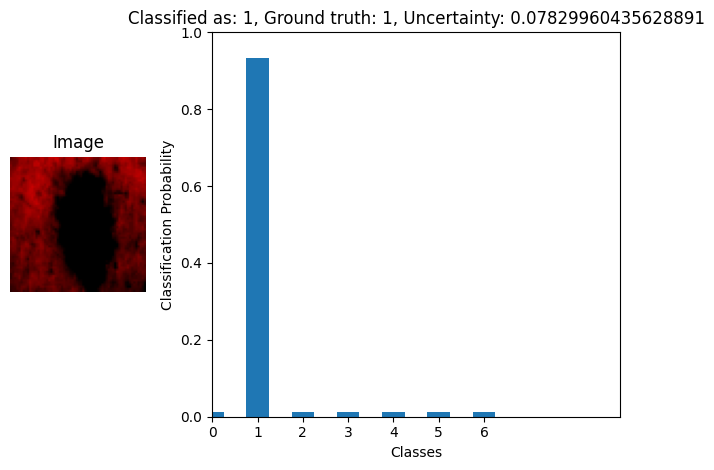

In [34]:
test_single_image(edl_resnet50_model, test_loader, uncertainty=True, is_mixup=False)

### **(ResNet50 + mixup + mse)**

 Lesion Types:  ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 

Original image shape:
 torch.Size([1, 3, 64, 64])

  Probs: tensor([0.0131, 0.9214, 0.0131, 0.0131, 0.0131, 0.0131, 0.0131],
       device='cuda:0')

  Prediction:  tensor(1, device='cuda:0')
  Ground truth: tensor(1)

  Uncertainty estimate: tensor([[0.0918]], device='cuda:0')  



<Figure size 700x500 with 0 Axes>

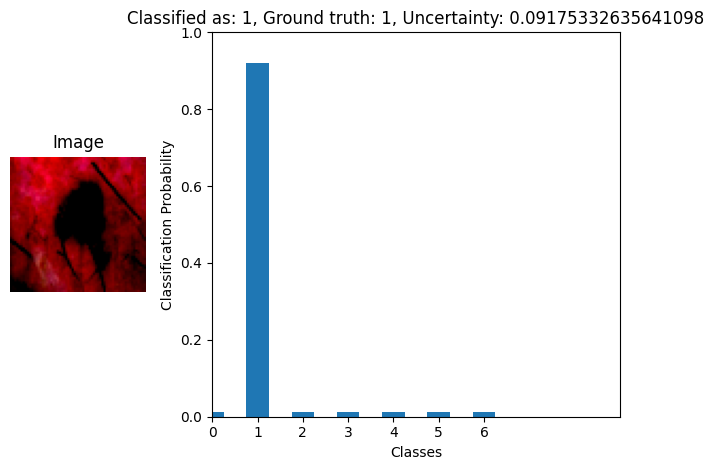

In [29]:
test_single_image(edl_resnet50_model, test_loader, uncertainty=True, is_mixup=True)

### **(VGG16 + Digamma)**

 Lesion Types:  ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 

Original image shape:
 torch.Size([1, 3, 64, 64])

  Probs: tensor([0.0210, 0.8737, 0.0210, 0.0210, 0.0210, 0.0210, 0.0210])

  Prediction:  tensor(1)
  Ground truth: tensor(1)

  Uncertainty estimate: tensor([[0.1473]])  



<Figure size 700x500 with 0 Axes>

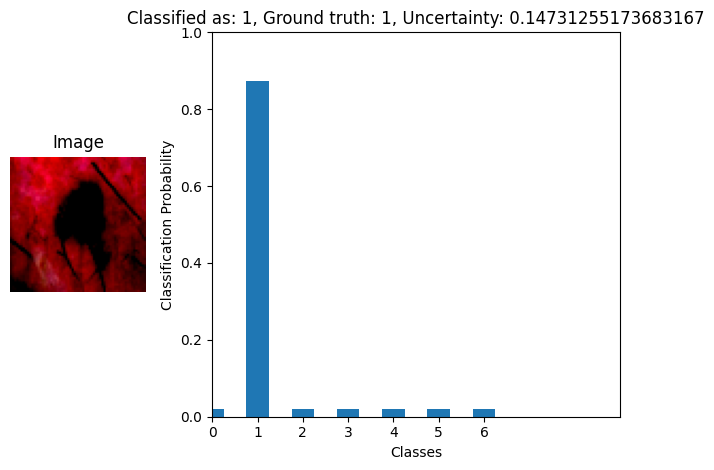

In [32]:
test_single_image(edl_VGG16_model, test_loader, uncertainty=True, is_mixup=False)

### **(VGG16 + Digamma + mixup)**

In [35]:
# Load VGG16 (WITH Mixup and Digamma loss)
checkpoint_VGG16_mixup = torch.load("/kaggle/input/vgg16_digamma_mixup/pytorch/default/1/VGG16_uncertainty_digamma_MIXUP.pt", map_location = torch.device(device))
edl_VGG16_model.load_state_dict(checkpoint_VGG16_mixup["model_state_dict"])  # Load the final saved model
optimizer_VGG16.load_state_dict(checkpoint_VGG16_mixup["optimizer_state_dict"])

/tmp/ipykernel_30/2689777051.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_VGG16_mixup = torch.load("/kaggle/input/vgg16_digamma_mixup/pytorch/default/1/VGG

 Lesion Types:  ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 

Original image shape:
 torch.Size([1, 3, 64, 64])

  Probs: tensor([0.0730, 0.5550, 0.0730, 0.0730, 0.0799, 0.0730, 0.0730])

  Prediction:  tensor(1)
  Ground truth: tensor(1)

  Uncertainty estimate: tensor([[0.5112]])  



<Figure size 700x500 with 0 Axes>

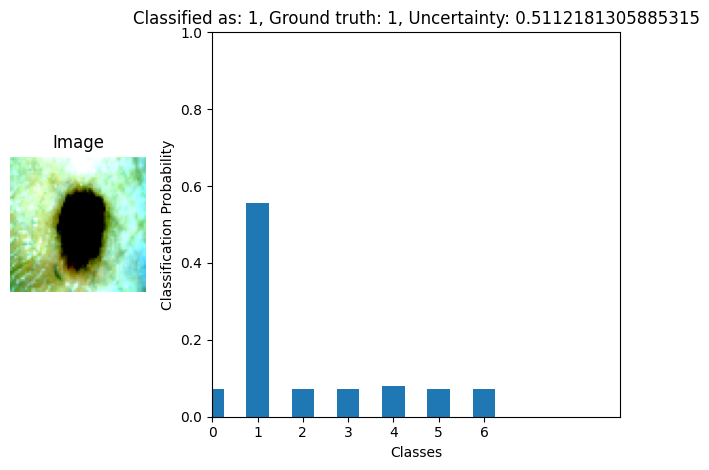

In [40]:
test_single_image(edl_VGG16_model, test_loader, uncertainty=True, is_mixup=True)

## 10. **Model metrics**

### **10.1 AUC Scores**

In [30]:
def auc_metric(model, test_loader, num_classes=num_classes, device=device):
    model.eval()  # Set model to evaluation mode

    all_labels, all_probs = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
        
            evidences = model(inputs)
            alpha = evidences + 1
            u = num_classes/torch.sum(alpha, dim=1, keepdim=True)
            est_probs = alpha/torch.sum(alpha, dim=1, keepdim=True)  
            all_probs.append(est_probs.cpu())  
        
            all_labels.append(labels.cpu())

    # Concatenate all predictions and labels
    all_probs = torch.cat(all_probs)
    all_labels = torch.cat(all_labels)

    if all_probs.size(1) == 2:  # Binary case
        auc = roc_auc_score(all_labels, all_probs[:, 1])  
    else:
        # For multiclass, calculate the AUC for each class and average
        auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    print(f"\033[1m AUC of loaded model: {auc:.4f} \033[0m")

### **AUC on Resnet50 (without mixup + mse)**

In [27]:
auc_metric(edl_resnet50_model, test_loader)

 AUC of loaded model: 0.8959


### **AUC metric on ResNet50 (mixup augmented + mse)**

In [ ]:
# # Load Resnet50 (WITH Mixup and mse loss)
# checkpoint_mixup = torch.load("/kaggle/input/resnet50_mse_mixup/pytorch/default/1/resnet50_uncertainty_mse_MIXUP.pt")
# edl_resnet50_model.load_state_dict(checkpoint_mixup["model_state_dict"])  # Load the final saved model
# optimizer_resnet50.load_state_dict(checkpoint_mixup["optimizer_state_dict"])

**Higher AUC score is expected for misclassification identification in uncertainty measure-driven applications.**

**Class Balanced EDL paper evaluated AUC = 0.854 on skin lesion screening.**

In [30]:
auc_metric(edl_resnet50_model, test_loader)

 AUC of loaded model: 0.9080


**That's a very good AUC score!!**

### **AUC on VGG16 (without mixup + digamma)**

In [60]:
# # LOAD VGG16 (Without mixup and digamma loss) model 
# checkpoint_vgg16 = torch.load("/kaggle/input/vgg16_digamma/pytorch/default/1/VGG16_uncertainty_digamma.pt")
# edl_VGG16_model.load_state_dict(checkpoint_vgg16["model_state_dict"])  # Load the final saved model
# optimizer_VGG16.load_state_dict(checkpoint_vgg16["optimizer_state_dict"])

/tmp/ipykernel_30/3383857680.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_vgg16 = torch.load("/kaggle/input/vgg16_digamma/pytorch/default/1/VGG16_uncertain

In [35]:
auc_metric(edl_VGG16_model, test_loader)

 AUC of loaded model: 0.8314 


### **AUC metric on VGG16 (mixup augmented + digamma)**

In [37]:
# Load VGG16 (WITH Mixup and Digamma loss)
checkpoint_VGG16_mixup = torch.load("/kaggle/input/vgg16_digamma_mixup/pytorch/default/1/VGG16_uncertainty_digamma_MIXUP.pt")
edl_VGG16_model.load_state_dict(checkpoint_VGG16_mixup["model_state_dict"])  # Load the final saved model
optimizer_VGG16.load_state_dict(checkpoint_VGG16_mixup["optimizer_state_dict"])

/tmp/ipykernel_30/1323229673.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_VGG16_mixup = torch.load("/kaggle/input/vgg16_digamma_mixup/pytorch/default/1/VGG

In [38]:
auc_metric(edl_VGG16_model, test_loader)

 AUC of loaded model: 0.8290 


### **10.2 Uncertainty Confusion metric**

**Use an "*uncertainty threshold*" to decide whether a prediction be called as uncertain or not**

In [31]:
def uncertainty_confusion_metric(model, test_loader, num_classes=num_classes, device=device):
    # store all uncertainty scores and predictions
    uncertainty_scores = []
    all_preds, all_labels = [], []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            evidences = model(inputs)
            alpha = evidences + 1
            uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True) 
            
            preds = torch.argmax(evidences, dim=1).cpu()
            uncertainty = uncertainty.cpu()
            labels = labels.cpu()
            
            # Append results
            uncertainty_scores.append(uncertainty)
            all_preds.append(preds)
            all_labels.append(labels)

    # Concatenate all stored results
    uncertainty_scores = torch.cat(uncertainty_scores)
    uncertainty_scores = uncertainty_scores.squeeze(dim=1)  # From [32, 1] to [32] tensor
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    print("\033[1mUncertainty scores:", uncertainty_scores, "\033[0m")
    print("Uncertainty scores shape:", uncertainty_scores.shape)
    print("all_preds shape:", all_preds.shape)
    print("all_labels shape:", all_labels.shape)
    print("-"*100)
    
    # Assume you have predictions, true labels, and uncertainty scores
    # `preds` is the predicted classes (shape: [num_samples])
    # `labels` is the true labels (shape: [num_samples])
    # `uncertainty_scores` is the uncertainty (shape: [num_samples])

    

    # Define an uncertainty threshold (e.g., median or fixed like 0.5)               # <---------------- THRESHOLDS
    thresholds = [torch.mean(uncertainty_scores).item(), torch.median(uncertainty_scores).item(), 0.2, 0.25, 0.35]  
    for i, threshold in enumerate(thresholds):
        if i==0:
            print("\n\033[1mUncertainty threshold (mean of uncertainty_scores) is:", threshold)
            print(f"i.e., when Model is at least {(1-threshold)*100}% confident:\033[0m\n")
        elif i==1:
            print("\n\033[1mUncertainty threshold (median of uncertainty_scores) is:", threshold)
            print(f"i.e., when Model is at least {(1-threshold)*100}% confident:\033[0m\n")
        else:
            print("\n\033[1mUncertainty threshold is:", threshold)
            print(f"i.e., when Model is at least {(1-threshold)*100}% confident:\033[0m\n")
    
        # CC:Correct&Certain, IC:Incorrect&Certain, CU:Correct&Uncertain, IU:Incorrect&Uncertain
        CC, IC, CU, IU = 0, 0, 0, 0
    
        for pred, label, uncertainty in zip(all_preds, all_labels, uncertainty_scores):
            # Set criterias for metrics
            correct = pred == label
            high_uncertainty = uncertainty > threshold             ## <---------- Determining Step
        
            if correct and not high_uncertainty:
                CC += 1
            elif not correct and not high_uncertainty:
                IC += 1
            elif correct and high_uncertainty:
                CU += 1
            elif not correct and high_uncertainty:
                IU += 1
    
        # Uncertainty Confusion matrix
        uncertainty_conf_matrix = torch.tensor([[CC, IC], [CU, IU]])
    
        print("\033[1mUncertainty Confusion Matrix:")
        print("[[CC, IC],")
        print("[CU, IU]]\n")
        print(uncertainty_conf_matrix)
        print("*"*100)

#### **10.2.1 (Resnet50 + mse)**

In [49]:
uncertainty_confusion_metric(edl_resnet50_model, test_loader)

Uncertainty scores: tensor([0.9919, 0.3234, 0.9561,  ..., 0.1036, 0.0587, 0.9953]) 
Uncertainty scores shape: torch.Size([1503])
all_preds shape: torch.Size([1503])
all_labels shape: torch.Size([1503])
----------------------------------------------------------------------------------------------------

Uncertainty threshold (mean of uncertainty_scores) is: 0.3093302249908447
i.e., when Model is at least 69.06697750091553% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[923,  80],
        [275, 225]])
****************************************************************************************************

Uncertainty threshold (median of uncertainty_scores) is: 0.12616461515426636
i.e., when Model is at least 87.38353848457336% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[722,  30],
        [476, 275]])
****************************************************************************************************

Uncertainty threshold is: 0.2
i.e.,

**IN CASE WHEN THRESHOLD == MEAN:**

* **Approximately 61.4% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~15% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~18.3% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~5.4% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**

**IN CASE WHEN THRESHOLD == MEDIAN:**

* **Approximately 48% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~18.3% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~31.66% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~2% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**

**IN CASE WHEN THRESHOLD == 0.2:**

* **Approximately 56% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~17% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~23.7% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~3.32% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**

**IN CASE WHEN THRESHOLD == 0.25:**

* **Approximately 58.5% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~16% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~21.16% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~4.3% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**

**IN CASE WHEN THRESHOLD == 0.35:**

* **Approximately 63.73% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~14.44% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~16% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~5.85% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**

#### **10.2.2 (Resnet50 + mixup + mse)**

In [32]:
uncertainty_confusion_metric(edl_resnet50_model, test_loader)

Uncertainty scores: tensor([0.9732, 0.2848, 0.6293,  ..., 0.0707, 0.0839, 0.8287]) 
Uncertainty scores shape: torch.Size([1503])
all_preds shape: torch.Size([1503])
all_labels shape: torch.Size([1503])
----------------------------------------------------------------------------------------------------

Uncertainty threshold (mean of uncertainty_scores) is: 0.31471094489097595
i.e., when Model is at least 68.5289055109024% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[887,  55],
        [316, 245]])
****************************************************************************************************

Uncertainty threshold (median of uncertainty_scores) is: 0.16671931743621826
i.e., when Model is at least 83.32806825637817% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[731,  21],
        [472, 279]])
****************************************************************************************************

Uncertainty threshold is: 0.2
i.e.,

**IN CASE WHEN THRESHOLD == MEAN:**

* **Approximately 59% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~16.3% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~21% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~3.66% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**
*  **Uncertainty Acc. = 0.7532 (= CC+IU/total)**
*  **Correct Certain Ratio = 0.6267 (best value closer to one)**

**IN CASE WHEN THRESHOLD == MEDIAN:**

* **Approximately 48.64% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~18.56% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~31.4% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~1.4% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**
*  **Uncertainty Acc. = 0.672**
*  **Correct Certain Ratio = 0.5**

**IN CASE WHEN THRESHOLD == 0.2:**

* **Approximately 51.3% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~17.83% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~28.64% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~2.13% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**
*  **Uncertainty Acc. = 0.69**
*  **Correct Certain Ratio = 0.534**

**IN CASE WHEN THRESHOLD == 0.25:**

* **Approximately 54.9% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~17.23% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~25.15% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~2.73% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**
*  **Uncertainty Acc. = 0.72**
*  **Correct Certain Ratio = 0.576**

#### **(VGG16 + Digamma)**

In [36]:
uncertainty_confusion_metric(edl_VGG16_model, test_loader)

Uncertainty scores: tensor([0.9992, 0.9975, 0.5828,  ..., 0.2257, 0.3941, 0.5033]) 
Uncertainty scores shape: torch.Size([1503])
all_preds shape: torch.Size([1503])
all_labels shape: torch.Size([1503])
----------------------------------------------------------------------------------------------------

Uncertainty threshold (mean of uncertainty_scores) is: 0.6009742617607117
i.e., when Model is at least 39.90257382392883% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[720,  63],
        [388, 332]])
****************************************************************************************************

Uncertainty threshold (median of uncertainty_scores) is: 0.5784565210342407
i.e., when Model is at least 42.15434789657593% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[696,  56],
        [412, 339]])
****************************************************************************************************

Uncertainty threshold is: 0.2
i.e., 

**IN CASE WHEN THRESHOLD == MEAN:**

* **Approximately 47.9% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~22% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~25.82% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~4.19% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**
*  **Uncertainty Acc. = 0.7(= CC+IU/total)**
*  **Correct Certain Ratio = 0.52 (best value closer to one)**

**IN CASE WHEN THRESHOLD == MEDIAN:**

* **Approximately 46.31% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~22.55% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~27.41% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~3.73% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**
*  **Uncertainty Acc. = 0.6886 (= CC+IU/total)**
*  **Correct Certain Ratio = 0.50 (best value closer to one)**

**IN CASE WHEN THRESHOLD == 0.2:**

* **Approximately 8.45% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~26.21% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~65.27% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~0.07% of the test data.**
* **Now in this case of VGG16, with at least 80% model confidence expected, CC test samples are less than IU and even CU, where CU samples being the most. So this model should be used if we want at least 80% confidence.**
*  **Uncertainty Acc. = 0.3466 (= CC+IU/total)**
*  **Correct Certain Ratio = 0.852 (best value closer to one)**

**IN CASE WHEN THRESHOLD == 0.25:**

* **Approximately 16.57% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~26.21% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~57.15% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~0.07% of the test data.**
* **Even if model confidence is reduced to at least 75%, results and conclusion is similar to >=80% model.**
*  **Uncertainty Acc. = 0.4278 (= CC+IU/total)**
*  **Correct Certain Ratio = 0.1663 (best value closer to one)**

#### **(VGG16 + Digamma + mixup)**

In [39]:
uncertainty_confusion_metric(edl_VGG16_model, test_loader)

Uncertainty scores: tensor([0.9999, 0.5983, 0.6380,  ..., 0.2046, 0.3010, 0.7700]) 
Uncertainty scores shape: torch.Size([1503])
all_preds shape: torch.Size([1503])
all_labels shape: torch.Size([1503])
----------------------------------------------------------------------------------------------------

Uncertainty threshold (mean of uncertainty_scores) is: 0.4965655505657196
i.e., when Model is at least 50.34344494342804% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[794, 110],
        [293, 306]])
****************************************************************************************************

Uncertainty threshold (median of uncertainty_scores) is: 0.3957834541797638
i.e., when Model is at least 60.42165458202362% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[695,  57],
        [392, 359]])
****************************************************************************************************

Uncertainty threshold is: 0.2
i.e., 

**IN CASE WHEN THRESHOLD == MEAN:**

* **Approximately 52.83% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~20.36% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~19.49% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~7.32% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**
*  **Uncertainty Acc. = 0.7319 (= CC+IU/total)**
*  **Correct Certain Ratio = 0.6015 (best value closer to one)**

**IN CASE WHEN THRESHOLD == MEDIAN:**

* **Approximately 46.24% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~23.89% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~26.08% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~3.79% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**
*  **Uncertainty Acc. = 0.7013 (= CC+IU/total)**
*  **Correct Certain Ratio = 0.50 (best value closer to one)**

**IN CASE WHEN THRESHOLD == 0.2:**

* **Approximately 16.03% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~27.61% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~56.29% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~0.07% of the test data.**
* **Even when mixup is used, VGG16 with Digamma loss is giving similar results and insights to when mixup wasn't applied.**
*  **Uncertainty Acc. = 0.4365 (= CC+IU/total)**
*  **Correct Certain Ratio = 0.1610 (best value closer to one)**

**IN CASE WHEN THRESHOLD == 0.25:**

* **Approximately 26.81% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~27.28% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~45.51% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~0.4% of the test data.**
* **Again CU is having the most test samples in its favor! Same conclusion as in case of 80% mixup applied model.**
*  **Uncertainty Acc. = 0.541 (= CC+IU/total)**
*  **Correct Certain Ratio = 0.2721 (best value closer to one)**

### **SaliencyMix augmentation**

In [ ]:
def saliency_bbox(img, lam):
    size = img.size()
    W = size[1]
    H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # initialize OpenCV's static fine grained saliency detector and compute the saliency map
    temp_img = img.cpu().numpy().transpose(1, 2, 0)
    saliency = cv2.saliency.StaticSaliencyFineGrained_create()
    (success, saliencyMap) = saliency.computeSaliency(temp_img)
    saliencyMap = (saliencyMap * 255).astype("uint8")

    maximum_indices = np.unravel_index(np.argmax(saliencyMap, axis=None), saliencyMap.shape)
    x = maximum_indices[0]
    y = maximum_indices[1]

    bbx1 = np.clip(x - cut_w // 2, 0, W)
    bby1 = np.clip(y - cut_h // 2, 0, H)
    bbx2 = np.clip(x + cut_w // 2, 0, W)
    bby2 = np.clip(y + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

## Focal Loss if selected

In [44]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  
        self.gamma = gamma  
        self.reduction = reduction  # 'mean' or 'sum'

    def forward(self, inputs, targets):
        # Apply softmax to get probabilities
        probs = F.softmax(inputs, dim=1)
        # Gather the probabilities of the true classes
        p_t = probs.gather(1, targets.unsqueeze(1)).squeeze(1)

        focal_term = (1 - p_t) ** self.gamma
        
        log_p_t = torch.log(p_t)
        
        # alpha is btw optional or can take as hyperparam
        if self.alpha is not None:
            at = self.alpha.gather(0, targets.data)
            loss = -at * focal_term * log_p_t
        else:
            loss = -focal_term * log_p_t
        
        # Apply reduction (mean or sum)
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

## Initial getting started model using AutoKeras

In [11]:
# X = np.asarray(skin_df['image'].tolist())
# X = X/255
# Y = skin_df['label']
# Y_cat = keras.utils.to_categorical(Y, num_classes=7)

In [12]:
# #Split the dataset Get a very small dataset for training as it will be fitted to many potential models to get NN.
# X_train_auto, X_test_auto, y_train_auto, y_test_auto = train_test_split(X, Y_cat, test_size=0.95, random_state=42)

# #Further split data into smaller size to get a small test dataset. 
# X_unused, X_valid, y_unused, y_valid = train_test_split(X_test_auto, y_test_auto, test_size=0.05, random_state=42)

In [15]:
# # Classifier for autokeras
# clf = ak.ImageClassifier(max_trials=15) # how many keras models to try at max
# clf.fit(X_train_auto, y_train_auto, epochs=25, batch_size=16)

Trial 15 Complete [00h 19m 26s]
val_loss: 0.7253139615058899

Best val_loss So Far: 0.5908347964286804
Total elapsed time: 02h 57m 41s
Epoch 1/25


2024-10-29 22:03:32.819360: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb7_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Not enough memory, reduce batch size to 8.
Epoch 1/25
Not enough memory, reduce batch size to 4.
Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 376ms/step - accuracy: 0.4766 - loss: 1.5284
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 375ms/step - accuracy: 0.7252 - loss: 0.8460
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 374ms/step - accuracy: 0.7760 - loss: 0.6753
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 374ms/step - accuracy: 0.7997 - loss: 0.5668
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 375ms/step - accuracy: 0.8717 - loss: 0.4051
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 373ms/step - accuracy: 0.9182 - loss: 0.2690
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 374ms/step - accuracy: 0.9320 - loss: 0.2338
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 373ms/step - accuracy: 0.9385 - loss: 0.1874
Epoch 9/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 373ms/step - accuracy: 0.9418 - loss: 0.1887
Epoch 10/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 374ms/step - accuracy: 0.9774 - loss: 0.1043
Epoch 11/25


In [16]:
# # Evaluation
# _, acc = clf.evaluate(X_valid, y_valid)
# print(f"Accuracy = {acc*100.0} %")

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 1424 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Not enough memory, reduce batch size to 16.
Not enough memory, reduce batch size to 8.
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.6918 - loss: 68.9690
Accuracy = 69.95798349380493 %


In [17]:
# get the best performing model
model = clf.export_model()
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32 (CastToFloat32) │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 32, 32, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 32, 32, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 7, 7, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        17,927 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1 (Softmax) │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,115,621 (244.58 MB)

 Trainable params: 63,804,887 (243.40 MB)

 Non-trainable params: 310,734 (1.19 MB)

None
